In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.patches as patches
from PIL import Image
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [501]:
datapath = '../CS148/RedLights2011_Medium/'
file = 'RL-016.jpg'

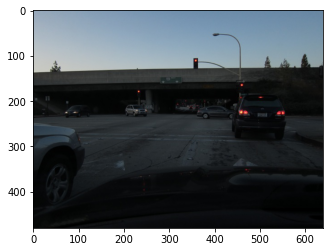

In [502]:
img=mpimg.imread(datapath+file)
imgplot = plt.imshow(img)
plt.show()

## Methods for Red Light Detection
1. Find pixels with highest red light intensity. If they are in contact, one light, otherwise multiple. In 8 cardinal directions, expand outward. If ratio of red is decreases to black, then red light.
2. Hough transform to get edges. Find rectangles with mostly black insides, with a bit of red, not other significant colors.
3. Circle hough transform/edge detector to find circles. If black box surrounding, then red light. Otherwise, use a metric of confidence. 
4. If red circle detected, then check two below + half of circle range for corners. If one or more corners found then yes.
5. Weighted ensemble trained on subset of data.

In [503]:
img = np.array(img)

img = np.array(Image.open(datapath+file), dtype=np.uint8)
print(img.shape)

(480, 640, 3)


In [504]:
redchannel = img[:,:,0]
greenchannel = img[:,:,1]
bluechannel = img[:,:,2]

In [505]:
redchannel.shape

(480, 640)

In [506]:
# find pixels where r > 200, g < 200, b < 200
im_dim0 = img.shape[0]
im_dim1 = img.shape[1]
print("im_dim0 cols", im_dim0)
print("im_dim1 rows", im_dim1)
new_img = img
count = 0
red_pixel_locations = []
for r in range(im_dim0):
    for c in range(im_dim1):
        if redchannel[r, c] > 240:
            if greenchannel[r, c] > 200 or bluechannel[r, c] > 200:
                new_img[r,c,0] = 255
                new_img[r,c,1] = 255
                new_img[r,c,2] = 255
            else:
                count += 1
                red_pixel_locations.append((r,c))
        else:
            new_img[r,c,0] = 255
            new_img[r,c,1] = 255
            new_img[r,c,2] = 255
print("count of red pixels", count)

im_dim0 cols 480
im_dim1 rows 640
count of red pixels 78


In [507]:
print('red_pixel_locations', red_pixel_locations)

red_pixel_locations [(110, 358), (110, 359), (110, 360), (111, 358), (111, 360), (112, 358), (112, 359), (164, 460), (164, 461), (165, 459), (165, 460), (165, 461), (166, 460), (179, 232), (192, 501), (192, 502), (223, 458), (223, 459), (223, 460), (223, 461), (223, 467), (223, 468), (223, 469), (223, 470), (224, 456), (224, 457), (224, 466), (224, 471), (224, 542), (224, 543), (224, 544), (225, 456), (225, 457), (225, 461), (225, 466), (225, 467), (225, 468), (225, 469), (225, 470), (225, 471), (225, 544), (225, 550), (225, 551), (225, 552), (226, 456), (226, 457), (226, 458), (226, 460), (226, 466), (226, 467), (226, 468), (226, 469), (226, 470), (226, 471), (226, 542), (226, 544), (226, 550), (226, 551), (226, 552), (226, 553), (227, 467), (227, 470), (227, 540), (227, 541), (227, 542), (227, 543), (227, 544), (227, 550), (227, 551), (227, 552), (227, 553), (228, 540), (228, 541), (228, 543), (228, 544), (228, 550), (228, 551), (228, 552)]


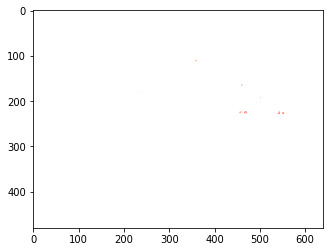

In [508]:
imgplot = plt.imshow(img)
plt.show()

In [509]:
# check that area around traffic light is black
new_red_pixel_locations = []
for entry in red_pixel_locations:
    (row, col) = entry
    # check 5 pixels up
    directional_sum = 0
    r=np.mean(img[row:min(row+5, im_dim0-1), col, 0])
    g=np.mean(img[row:min(row+5, im_dim0-1), col, 1])
    b=np.mean(img[row:min(row+5, im_dim0-1), col, 2])
    if r+g+b>650:
        directional_sum+=1
        
    # check 5 pixels down
    r=np.mean(img[max(0, row-15):row, col, 0])
    g=np.mean(img[max(0, row-15):row, col, 1])
    b=np.mean(img[max(0, row-15):row, col, 2])
    if r+g+b>650:
        directional_sum+=1
        
#     check 5 pixels left
    r=np.mean(img[row, max(0, col-5):col, 0])
    g=np.mean(img[row, max(0, col-5):col, 1])
    b=np.mean(img[row, max(0, col-5):col, 2])
    if r+g+b>650:
        directional_sum+=1
        
    # check 5 pixels right
    r=np.mean(img[row, col:min(im_dim1-1, col-5), 0])
    g=np.mean(img[row, col:min(im_dim1-1, col-5), 1])
    b=np.mean(img[row, col:min(im_dim1-1, col-5), 2])
    if r+g+b>650:
        directional_sum+=1
    if directional_sum >= 3:
        new_red_pixel_locations.append(entry)

In [510]:
def compute_euclidean(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [511]:
# filters new_red_pixel_locations based on overlap
# 30x30 boxes
overlap_red_pixels = []
skip = []
# new_red_pixel_locations = []
for entry_i in range(len(new_red_pixel_locations)):
    if entry_i in skip:
        overlap_red_pixels.append(100)
        continue
    (curr_row, curr_col) = new_red_pixel_locations[entry_i]
    overlap_count = 0
    for entry_j in range(len(new_red_pixel_locations)): 
        (neighbor_row, neighbor_col) = new_red_pixel_locations[entry_j]
        if entry_j != entry_i:
            distance = compute_euclidean(curr_row, curr_col, neighbor_row, neighbor_col)
            if distance < 5:
                skip.append(entry_j)
            
            if distance < 30:
#                 skip.append(new_red_pixel_locations[entry_j])
                overlap_count += 1
    overlap_red_pixels.append(overlap_count)
    
# filter once
final_red_pixel_locations = []
for i in range(len(overlap_red_pixels)):
    if overlap_red_pixels[i] < 10:
        final_red_pixel_locations.append(new_red_pixel_locations[i])
    
# FILTER TWICE
new_red_pixel_locations = final_red_pixel_locations
overlap_red_pixels = []
skip = []
# new_red_pixel_locations = []
for entry_i in range(len(new_red_pixel_locations)):
    if entry_i in skip:
        overlap_red_pixels.append(100)
        continue
    (curr_row, curr_col) = new_red_pixel_locations[entry_i]
    overlap_count = 0
    for entry_j in range(len(new_red_pixel_locations)): 
        (neighbor_row, neighbor_col) = new_red_pixel_locations[entry_j]
        if entry_j != entry_i:
            distance = compute_euclidean(curr_row, curr_col, neighbor_row, neighbor_col)
            if distance < 5:
                skip.append(entry_j)
            
            if distance < 30:
#                 skip.append(new_red_pixel_locations[entry_j])
                overlap_count += 1
    overlap_red_pixels.append(overlap_count)
    
# second filter
final_red_pixel_locations = []
for i in range(len(overlap_red_pixels)):
    if overlap_red_pixels[i] <= 1:
        final_red_pixel_locations.append(new_red_pixel_locations[i])


In [512]:
final_red_pixel_locations

[(110, 359),
 (164, 461),
 (179, 232),
 (192, 501),
 (223, 458),
 (226, 466),
 (226, 542),
 (227, 550)]

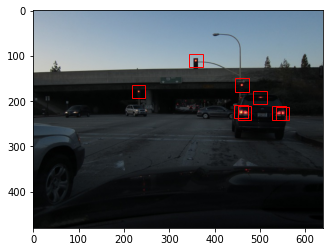

In [513]:
im = np.array(Image.open(datapath+file), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for entry in final_red_pixel_locations:
    (row, col) = entry
    rect = patches.Rectangle((col-15, row-15),30,30,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [514]:
# red rgb(255,0,0)

In [262]:
# import numpy as np
# import cv2

# image = cv2.imread(datapath+file)
# result = image.copy()
# image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# lower = np.array([155,25,0])
# upper = np.array([179,255,255])
# mask = cv2.inRange(image, lower, upper)
# result = cv2.bitwise_and(result, result, mask=mask)

# cv2.imshow('mask', mask)
# cv2.imshow('result', result)
# cv2.waitKey()